## Read data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('OxCGRT_latest.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Engineering

- Only use the US regional data.
- Convert the date column to Datetime
- delete datapoints with null vaccination policy

In [2]:
data_usa = data[data['CountryCode']=='USA']

#drop nationwide data
data_usa = data_usa.dropna(subset=['RegionName'])

#convert int date to datetime
data_usa['Datetime'] = pd.to_datetime(data_usa['Date'], format='%Y%m%d')

#only look at data between 2020-12-1 and 2021-6-1 (when policy change is happening)
data_usa = data_usa[(data_usa['Datetime']<pd.Timestamp(2021,6,1)) & (data_usa['Datetime']>pd.Timestamp(2020,12,1))]

In [3]:
data_vacpol_usa = data_usa[['RegionName', 'H7_Vaccination policy', 'Datetime']]

In [4]:
data_vacpol_usa['H7_Vaccination policy'].value_counts(dropna=False)

5.0    2848
2.0    2703
3.0    2209
1.0     452
0.0     376
4.0     326
NaN     317
Name: H7_Vaccination policy, dtype: int64

In [5]:
# Create a new dataframe with states as features
df_states = data_vacpol_usa.pivot(index='RegionName', columns='Datetime')['H7_Vaccination policy']

#Drop any columns with at least one NaN
df_states = df_states.dropna(axis='columns')

In [6]:
df_states.head()

Datetime,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,...,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29,2021-05-30
RegionName,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Alaska,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Arizona,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Arkansas,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
California,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


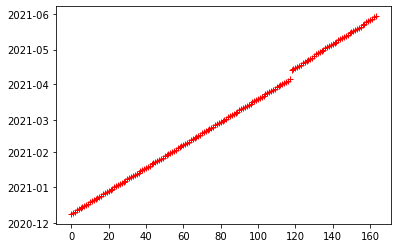

In [7]:
#check if data points are coving enough time range
plt.plot(df_states.columns, 'r+')

## Create a distance matrix and 

l1 distance.

In [8]:
from scipy.spatial import distance_matrix
df = df_states
X = pd.DataFrame(distance_matrix(df.values, df.values, p=1), 
                 index=df.index, columns=df.index)

In [38]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 4
clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(X)

states = df_states.index

#create a dictionary which maps states to group number
# ex) 'Alabama':1
dict_stategroups = dict(zip(states,clustering.labels_ ))
print(dict_stategroups)

#OR if you want a state code ('AL') to be a key...
# from states_dictionary import us_state_to_code

# dict_code2groups = dict()
# dict_to_code = us_state_to_code()

# for state in states:
#     code = dict_to_code[state]
#     dict_code2groups[code] = dict_stategroups[state]
# print(dict_code2groups)

{'Alabama': 1, 'Alaska': 0, 'Arizona': 3, 'Arkansas': 2, 'California': 1, 'Colorado': 3, 'Connecticut': 0, 'Delaware': 3, 'Florida': 0, 'Georgia': 0, 'Hawaii': 1, 'Idaho': 1, 'Illinois': 1, 'Indiana': 0, 'Iowa': 3, 'Kansas': 3, 'Kentucky': 1, 'Louisiana': 0, 'Maine': 1, 'Maryland': 2, 'Massachusetts': 1, 'Michigan': 1, 'Minnesota': 1, 'Mississippi': 0, 'Missouri': 0, 'Montana': 2, 'Nebraska': 2, 'Nevada': 1, 'New Hampshire': 2, 'New Jersey': 2, 'New Mexico': 2, 'New York': 1, 'North Carolina': 1, 'North Dakota': 2, 'Ohio': 2, 'Oklahoma': 1, 'Oregon': 2, 'Pennsylvania': 2, 'Rhode Island': 1, 'South Carolina': 0, 'South Dakota': 1, 'Tennessee': 1, 'Texas': 2, 'Utah': 1, 'Vermont': 1, 'Virginia': 2, 'Washington': 1, 'Washington DC': 2, 'West Virginia': 2, 'Wisconsin': 1, 'Wyoming': 2}


/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [18]:
#show groups

state_groups = [list(X.index[clustering.labels_== i]) for i in range(n_clusters)]

for i in range(n_clusters):
    print('group ', chr(i+65),':', state_groups[i])

group  A : ['Alaska', 'Connecticut', 'Florida', 'Georgia', 'Indiana', 'Louisiana', 'Mississippi', 'Missouri', 'South Carolina']
group  B : ['Alabama', 'California', 'Hawaii', 'Idaho', 'Illinois', 'Kentucky', 'Maine', 'Massachusetts', 'Michigan', 'Minnesota', 'Nevada', 'New York', 'North Carolina', 'Oklahoma', 'Rhode Island', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Washington', 'Wisconsin']
group  C : ['Arkansas', 'Maryland', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico', 'North Dakota', 'Ohio', 'Oregon', 'Pennsylvania', 'Texas', 'Virginia', 'Washington DC', 'West Virginia', 'Wyoming']
group  D : ['Arizona', 'Colorado', 'Delaware', 'Iowa', 'Kansas']


Compare vaccination policy for each group

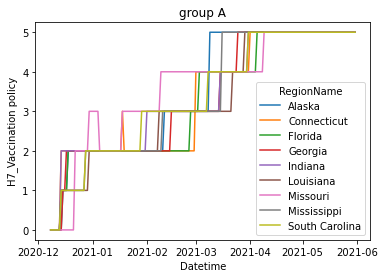

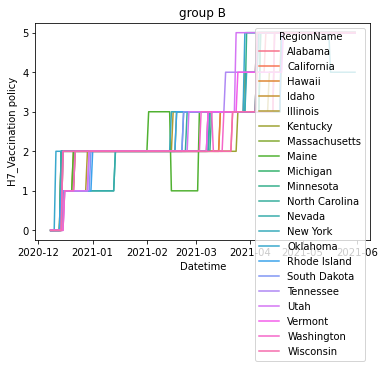

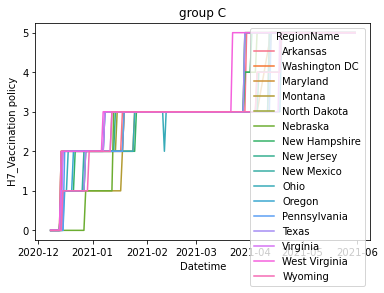

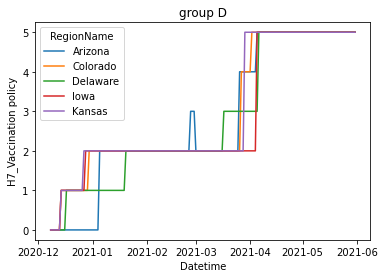

In [12]:
for i in range(n_clusters):
    data_onereg = data_usa[data_usa['RegionName'].isin(state_groups[i])]
    sns.lineplot(data=data_onereg, x='Datetime', y='H7_Vaccination policy', hue="RegionName")
    plt.title('group '+chr(i+65))
    plt.show()